# Monthly analysis of snow cover in North Tyrol 

The setup for the Fractional Snow Cover (FSC) analysis is the same as for the Persistent Snow Area.  
However FSC data is more complex since it is provided at the same interval as Sentinel 2 data, which is up to every 5 days.  
Comparing that to PSA, where data is generated only once a year makes it obvious that the analysis has to be carried out more efficiently to be able to handle these large amounts of data.

In [1]:
from pathlib import Path
import tarfile
import shutil
import tempfile
import os
import time
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    Geometry,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
    MimeType,
    parse_time,
)

# Pass Sentinel Hub credentials to SHConfig
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]
config.sh_base_url = "https://creodias.sentinel-hub.com"

## Loading area of interest

In [2]:
# Load in north tyrol
tyrol = gpd.read_file("input/north_tyrol.geojson")
# simplify geom to pass into payload 
tyrol_simple = tyrol.geometry.simplify(100)
geom = tyrol_simple[0]
geom_sh = Geometry(geom, CRS(3035))

## Defining used data

Here we define which data sources we want to use. In this case we are using the gap filled fractional snow cover (GFSC) product from the HR-S&I dataset as well as the digital elevation model and the derived aspect values for Austria.

In [ ]:
asp = DataCollection.define_byoc("fb426a12-f21d-4c9a-8848-eb4eca836bc9")
gfsc = DataCollection.define_byoc("e0e66010-ab8a-46d5-94bd-ae5c750e7341")

### Helper functions

These are two helper functions which help to make the requests to the datacube and which handle the data which is downloaded from the requests.

In [ ]:
def get_request(
    input_data, 
    evalscript,
    geometry):
    """Specify Sentinel Hub Request

    Returns a Sentinel Hub Request based on some parameters.

    Params:
        input_data (SentinelHubRequest.input_data): an input data object
        evalscript (str): An evalscript to use in the request
        geometry (sentinelhub.Geometry): A sentinelhub.Geometry Object 
            representing the area of interest

    Returns:
        (sentinelhub.SentinelHubRequest) request with the passed in values set

    """
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[
            SentinelHubRequest.output_response("default", MimeType.TIFF), 
            SentinelHubRequest.output_response("userdata", MimeType.JSON)],
        geometry=geometry,
        config=config,
        resolution=(100,100),
        data_folder=tempfile.gettempdir()
    )

def get_data(request, downloaded_data, file_path, **kwargs):
    """Utility function to handle the downloaded data
    
    This function does a few things: 
    
    1. It gets the json from the downloaded data and 
    opens it into a pandas dataframe. 
    2. It moves the data saved locally to a permanent location
    specified in `file_path`
    3. It adds metadata to the pandas dataframe

    Params:
        request (sentinelhub.SentinelHubRequest): A
            Sentinelhubrequest
        downloaded_data (dict): The downloaded data from
            the request
        file_path (Union[str, PathLike]): File path where
            the image file from the request data should be 
            saved to
        **kwargs will be saved into the pandas dataframe
            where the keys are the column names and the
            values the values in the rows.
    
    Returns:
        (pd.DataFrame) A pandas dataframe built from the
            output of userdata.json
    
    """
    stats = downloaded_data["userdata.json"]

    # Move tif from zipped folder to outputs, rename and delete folder
    output = Path(tempfile.gettempdir()) / request.get_filename_list()[0]
    with tarfile.open(output, "r:") as tar:
        tar.extract("default.tif") 
    Path(file_path).parent.mkdir(parents=True, exist_ok=True) 
    Path("default.tif").replace(file_path)
    shutil.rmtree(output.parent)

    # Make the dataframe
    df = pd.DataFrame(stats).T.reset_index(names="class")
    # Split the class into its keys
    df[["aspect", "elevation_below"]] = df["class"].str.split("_", n=1, expand=True)
    # Make all columns given as kwargs
    df[list(kwargs.keys())] = list(kwargs.values())
    return df

## Querying the Datacube

Sentinel Hub is a form of datacube, providing access to large amounts of data which can be quite complex.

In the case of FSC the analysis is made difficult by the variance in spatial and temporal availability of data. Not all pixels in our AOI have data at
the same time due to clouds and the general acquisition patterns of the Sentinel 2 satellites. However to carry out meaningful analysis, data for the entire AOI has to be available at every time step. Because of this the data has to be mosaicked at a time frame that maximizes the availability of data for the entire AOI. 

This mosaicking can easily be done using the services provided by Sentinel Hub to query available data. For example by using evalscripts and the different available querying APIs like Processing API. By using these services, analysis ready data can be immediately returned, leveraging cloud computing capabilities to perform computationally expensive tasks to return only the data which is really needed. 

### Evalscript

The evalscript together with the API request performs multiple key tasks:

- Resamples the data to the chosen resolution
- Mosaicks all available data points in the chosen time frame using a custom mosaicking strategy
  - Only pixels with 100% snow cover were counted as snow covered
  - Pixels which at any point during the month were 100% covered by snow were recorded as snow
- Returns image statistics for different elevation and aspect classes

It is important to note that the mosaicking strategy can easily be adapted to suit more other needs.

For more information on how to build evalscripts see the [documentation](https://docs.sentinel-hub.com/api/latest/evalscript/).

In [ ]:
with open("input/eval_fsc.js", "r") as file:
    evalscript = file.read()

In [ ]:
out_paths = []
sh_requests = []
kwargs = []
seasons = [2017, 2020]

for season in seasons:
    # This is the start and end of the period you want to check
    # It will make monthly mosaics and output them into a folder
    start = f"{season}-08-01"
    end = f" {season+1}-08-01"
    year_months = pd.date_range(start,end, 
                freq='MS').strftime("%Y-%m").tolist()
    for i in range(len(year_months)-1):
        input_data = [
                SentinelHubRequest.input_data(
                    data_collection=gfsc,
                    identifier="gfsc", 
                    time_interval=(f"{year_months[i]}-01", f"{year_months[i+1]}-01"),
                ),
                SentinelHubRequest.input_data(
                    data_collection=asp,
                    identifier="asp"
                )
            ]
        file_path = f"./output/gfsc/gfsc_{year_months[i]}.tif"
        out_paths.append(file_path)
        request = get_request(input_data, evalscript, geom_sh)
        sh_requests.append(request)
        kwargs.append(dict(year_month=year_months[i], season=season))

In [ ]:
t0 = time.time()
# create a list of requests
dl_requests = [request.download_list[0] for request in sh_requests]

# download data with multiple threads
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)
dfs = [get_data(request, download, out_path, **kwarg) 
        for request, download, out_path, kwarg 
        in zip(sh_requests, downloaded_data, out_paths, kwargs)]
del downloaded_data

print(time.time()-t0)

In [ ]:
all_data = pd.concat(dfs)
all_data["elevation_below"] = all_data["elevation_below"].astype(int)
all_data["percent_snow_cover"] = all_data["sum"] / all_data["count"]
all_data["km2_snow"] = (0.1*0.1)*all_data["sum"]
all_data["km2_all"] = (0.1*0.1)*all_data["count"]
all_data[["year", "month"]] = all_data["year_month"].str.split("-", n=1, expand=True)
all_data.to_csv("./output/fsc_tyrol.csv")
all_data

## Analysis of queried data

From the requests issued above you get back data which can be immediately used to carry out analysis.   

In [3]:
all_data = pd.read_csv("./output/fsc_tyrol.csv")

### Comparing snow cover in two seasons

Here we compare the evolution of snow cover in North Tyrol over two periods: August 2017 - July 2018 and August 2020 - July 2021. The periods were selected based on the previous PSA analysis, where 2018 and 2021 where the years with minimum and maximum snow cover, respectively.  

In [4]:
# Aggregate dataframe to months and calculate which percentage of pixels are covered by snow  
total = all_data.groupby(["season", "month"])[["sum", "count"]].sum()
total["percent_covered"] = total["sum"] / total["count"]
total

sum    count  percent_covered
season month                                  
2017   1      767765  1064983         0.720918
       2      857951  1064983         0.805601
       3      738884  1064983         0.693799
       4      623920  1064983         0.585850
       5      359379  1064983         0.337450
       6      215345  1064983         0.202205
       7      114626  1064983         0.107632
       8       67877  1064983         0.063735
       9      245943  1064983         0.230936
       10     340963  1064983         0.320158
       11     635241  1064983         0.596480
       12     866282  1064983         0.813423
2020   1      794712  1064983         0.746220
       2      714868  1064983         0.671248
       3      797813  1064983         0.749132
       4      624845  1064983         0.586718
       5      447871  1064983         0.420543
       6      283030  1064983         0.265760
       7      194406  1064983         0.182544
       8      111178  1064983         0.104394
       9      117173  1064983         0.110023
       10     363572  1064983         0.341388
       11     371800  1064983         0.349114
       12     533444  1064983         0.500894

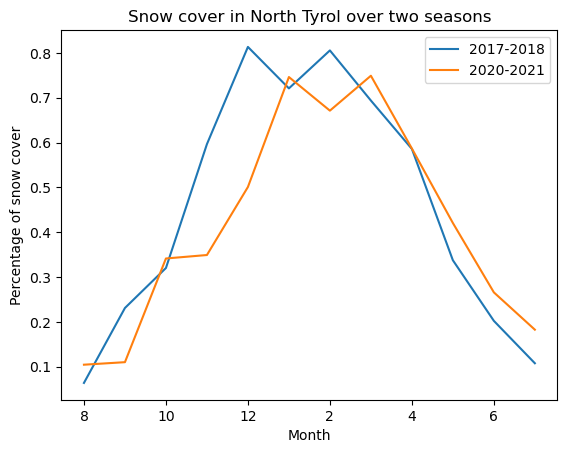

In [5]:
months = np.arange(1,13)
idx = np.roll(months, 7)
replace = {A: B for A, B in zip(months, idx)}

test = total["percent_covered"].unstack(level='season')
test["month"] = test.index
test.index = test.index.astype(str)
test["id"] = test["month"].replace(replace)
test.sort_values("id").plot(y=[2017, 2020], title="Snow cover in North Tyrol over two seasons", xlabel="Month", ylabel="Percentage of snow cover")
plt.legend(['2017-2018','2020-2021']);

The chart depicts the onset and end of the snow season over the two periods. The period 2017-2018 had an earlier onset, with peaks in November and February reaching around 80% of snow cover. On the other hand, the period with maximum snow cover (2020-2021) had a later onset and end, with peaks of snow cover in January and March reaching 70% of snow cover in North Tyrol relative to that period. 

### Impact of Aspect on the snow cover

To analyse the impact of aspect on snow cover, the data was filtered to only include North and South facing slopes which are above 1500 meters.

In [6]:
# Filtering the data to only include North and South facing slopes, which are above 1500 m
aspect_filtered = all_data.loc[np.logical_and(np.isin(all_data.aspect, [0,180]), all_data.elevation_below > 1500)]
aspect = aspect_filtered.groupby(["season", "month", "aspect"])[["sum", "count"]].sum()
aspect["percent_covered"] = aspect["sum"] / aspect["count"]
asp_unstack = aspect["percent_covered"].unstack(level=["aspect", "season"])

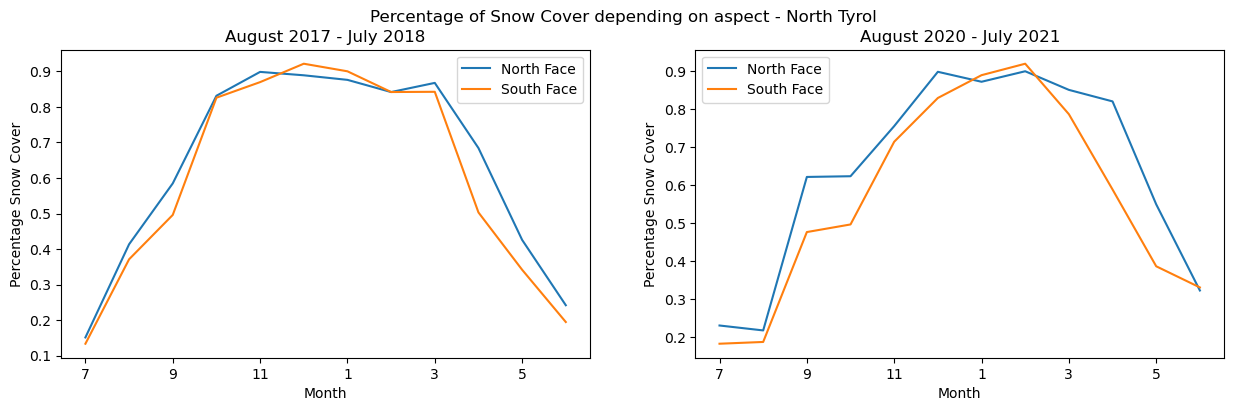

In [7]:
asp_plt = asp_unstack.reset_index()
asp_plt.index = asp_plt.index.astype(str)
asp_plt["id"] = asp_plt["month"].replace(replace)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
labels = dict(xlabel="Month", ylabel="Percentage Snow Cover")
asp_plt.sort_values("id").plot(y=[(0, 2017), (180, 2017)], ax=ax1, title="August 2017 - July 2018", **labels)
asp_plt.sort_values("id").plot(y=[(0, 2020), (180, 2020)], ax=ax2, title="August 2020 - July 2021", **labels)

ax1.legend(["North Face", "South Face"]);
ax2.legend(["North Face", "South Face"]);
fig.suptitle("Percentage of Snow Cover depending on aspect - North Tyrol");

It can be seen that in both seasons, but especially in the season 2020-2021, the snow cover on South faces especially in autumn and spring is not as extensive as on North Faces. However, during the peak snow season around January and February, snow cover is comparably high for both aspects.

### Impact of Elevation on Snow Cover

To analyse the impact of elevation on snow cover over a season, only the elevations between 1500-4000 meters were taken into account.

In [8]:
elev_filtered = all_data.loc[np.logical_and.reduce((
    all_data.elevation_below < 4500, 
    all_data.elevation_below > 1500))]

elev = elev_filtered.groupby(["season","month", "elevation_below"])[["sum", "count"]].sum()
elev["percent_covered"] = elev["sum"] / elev["count"]
elev_unstack = elev["percent_covered"].unstack(level=["elevation_below", "season"])

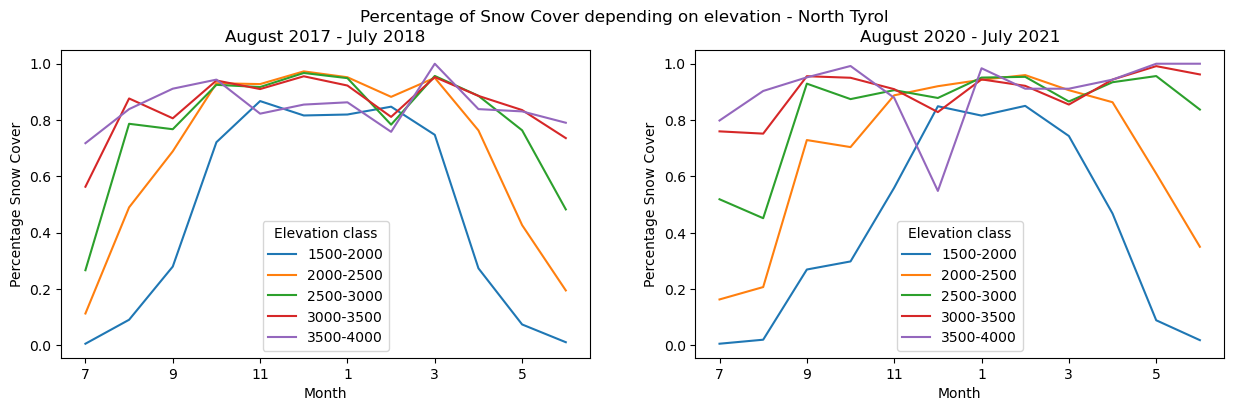

In [10]:
elev_plt = elev_unstack.reset_index()
elev_plt.index = elev_plt.index.astype(str)
elev_plt["id"] = elev_plt["month"].replace(replace)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
labels = dict(xlabel="Month", ylabel="Percentage Snow Cover")
elev_plt.sort_values("id").plot(y=[(2000, 2017), (2500, 2017),(3000, 2017), (3500, 2017),(4000, 2017)], ax=ax1, title="August 2017 - July 2018", **labels)
elev_plt.sort_values("id").plot(y=[(2000, 2020), (2500, 2020),(3000, 2020), (3500, 2020),(4000, 2020)], ax=ax2, title="August 2020 - July 2021", **labels)

ax1.legend(["1500-2000", "2000-2500", "2500-3000", "3000-3500", "3500-4000"], title = 'Elevation class');
ax2.legend(["1500-2000", "2000-2500", "2500-3000", "3000-3500", "3500-4000"], title = 'Elevation class');
fig.suptitle("Percentage of Snow Cover depending on elevation - North Tyrol");

These plots indicate that the difference in the distribution of snow cover over the elevation classes is more significant in the period with maximum snow cover. 
As expected, in most of the cases, the higher the elevation the greater the snow cover. 
An interesting observation is that at high alpine elevations between 3500 and 4000 meters, in the peak snow season between November and March, the snow cover actually decreases, particularly between Ausgust 2020 - July 2021. This phenomenon requires further analysis. 

## Summary

- The monthly FSC dataset enabled us to go into more detail on the monthly variations of the periods with minimum and maximum snow cover. 
- An earlier onset and end of the snow season was found in the period with minimum snow cover (2017-2018).
- Particularly for the period 2020 - 2021, South faces have lower snow cover in the season than North faces. During the peak snow season (Jan - Feb), both slope faces have similar amount of snow cover.
- Higher elevations tend to have more snow cover than lower elevations. 
- In this section, we looked at the monthly dynamics (differences and similarities) between the snow seasons of the periods with minimum and maximum snow cover. Now, what does the wet/dry snow ratio can tell us about the factors that influenced these periods?